In [19]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet

def median_filter(s, window=24, n_sigmas=2.5): 
    """
    A simple median filter, removes (i.e. replace by np.nan) observations that exceed N (default = 2.5) 
    tandard deviation from the median over window of length P (default = 24) centered around 
    each observation.
    Parameters
    ----------
    s : pandas.Series
        The series to filter
    window : integer 
        Size of the window around each observation for the calculation 
        of the median and std. Default is 24 (time-steps).
    n_sigmas : integer 
        Threshold for the number of std around the median to replace 
        by `np.nan`. Default is 2.5 (greater / less or equal).
    Returns
    -------
    s : pandas.Series
        The filtered series with "outliers" replaced with np.nan
    """
    
  
    med = s.rolling(window, center=True).median()
    sigma = s.rolling(window, center=True).std()
    
    upper_lim = med + n_sigmas * sigma
    lower_lim = med - n_sigmas * sigma
    
    return s.where(s.between(lower_lim, upper_lim), np.nan)


def preprocess_data(df):
    return (df.assign(
                  ds=df['timestamp_MTN'],
                  y=median_filter(df['value'].where(df['value'] > 0, np.nan))
                     )
           )

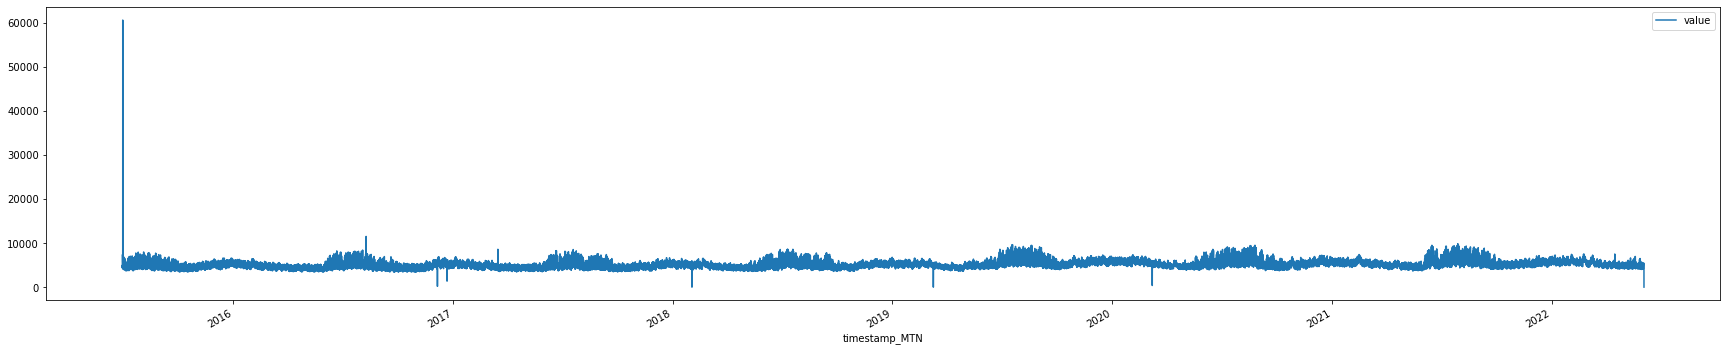

In [4]:
client = bigquery.Client()
q = "SELECT * FROM `de-zoomcamp-347002.energy_data_prod.fact_eia_demand_historical`"
df_raw = pd.read_gbq(q, project_id='de-zoomcamp-347002')
df_raw.plot(x='timestamp_MTN', y='value', figsize=(30, 6))

In [15]:
df_train_raw = df_raw[df_raw['timestamp_MTN'] < pd.to_datetime('2021-06-01')]
df_test_raw = df_raw[df_raw['timestamp_MTN'].between(pd.to_datetime('2021-06-01'), pd.to_datetime('2022-06-01'))]

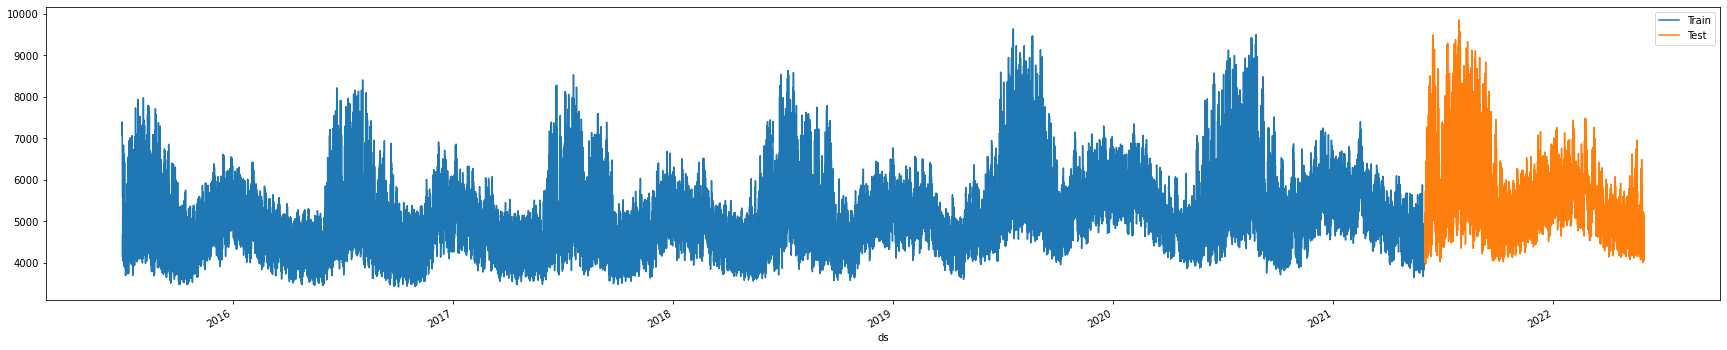

In [20]:
df_train_clean = preprocess_data(df_train_raw)
df_test_clean = preprocess_data(df_test_raw)

fig, ax = plt.subplots()
df_train_clean.plot(x='ds', y='y', figsize=(30, 6), ax=ax, label='Train')
df_test_clean.plot(x='ds', y='y', figsize=(30, 6), ax=ax, label='Test')



In [21]:
# Python
m = Prophet()
m.fit(df_train_clean)

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -568.703
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        128456    0.00708061       4040.69           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        128649     0.0141346        4469.5      0.3466      0.8932      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        128757     0.0141946        4337.4      0.3401      0.9266      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        128822    0.00231711       1546.49           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        128866     0.0168376       2242.92           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

   128905     0.0117148       2425.09       0.768       0.768      688   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        128952     0.0362579       1533.79           1           1      804   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799        128966    0.00175126       1490.25           1           1      913   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        128975   0.000339514       721.649      0.3622      0.3622     1026   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        128982    0.00106422       1218.68      0.4139      0.4139     1144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099        128989    0.00537107       3249.63      0.3018           1     1253   
    Iter      log prob        |

In [22]:
# Python
future = m.make_future_dataframe(freq='H', periods=36)
future.tail()

,ds
51912,2021-06-02 07:00:00
51913,2021-06-02 08:00:00
51914,2021-06-02 09:00:00
51915,2021-06-02 10:00:00
51916,2021-06-02 11:00:00


In [23]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
51912,2021-06-02 07:00:00,4950.744432,4333.061377,5540.961219
51913,2021-06-02 08:00:00,5174.423797,4560.488675,5789.392809
51914,2021-06-02 09:00:00,5333.435328,4695.942044,5950.860654
51915,2021-06-02 10:00:00,5427.056496,4842.041926,6062.310770
51916,2021-06-02 11:00:00,5487.562097,4892.890438,6122.007966


[(0.0, 10000.0), (737791.0, 738311.0)]

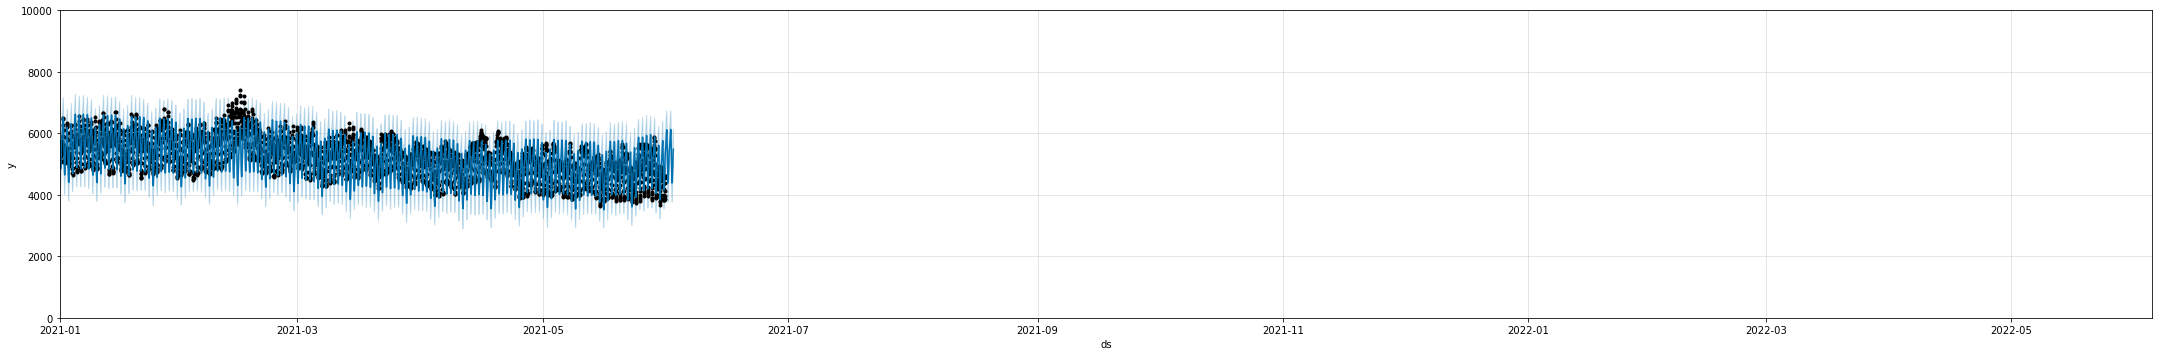

In [24]:
# Python
fig1 = m.plot(forecast, figsize=(30,5))
fig1.get_axes()[0].set(ylim=(0, 10000), xlim=(pd.to_datetime('01-01-2021'), pd.to_datetime('06-05-2022')))

[(0.0, 10000.0), (737942.0, 738032.0), Text(0.5, 1.0, 'Summer 2021')]

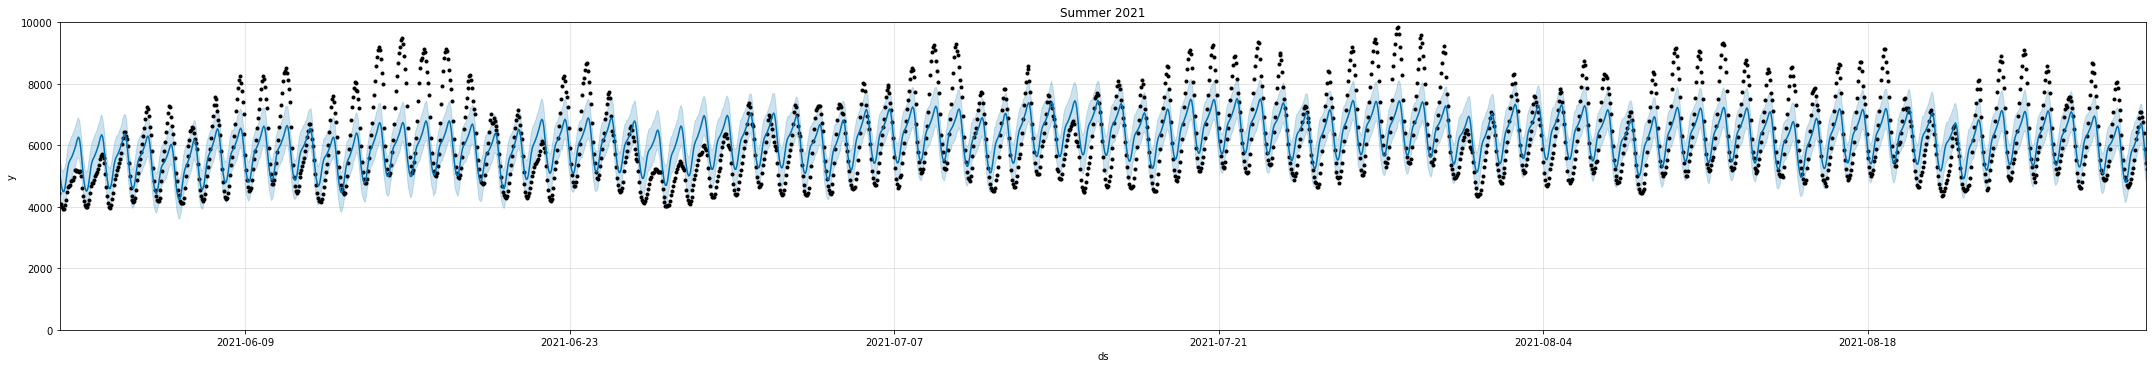

In [9]:
# Python
fig2 = m.plot(forecast, figsize=(30,5))
fig2.get_axes()[0].set(title='Summer 2021', ylim=(0, 10000), xlim=(pd.to_datetime('2021-06-01'), pd.to_datetime('2021-08-30')))

[(0.0, 10000.0), (738156.0, 738229.0), Text(0.5, 1.0, 'Early 2022')]

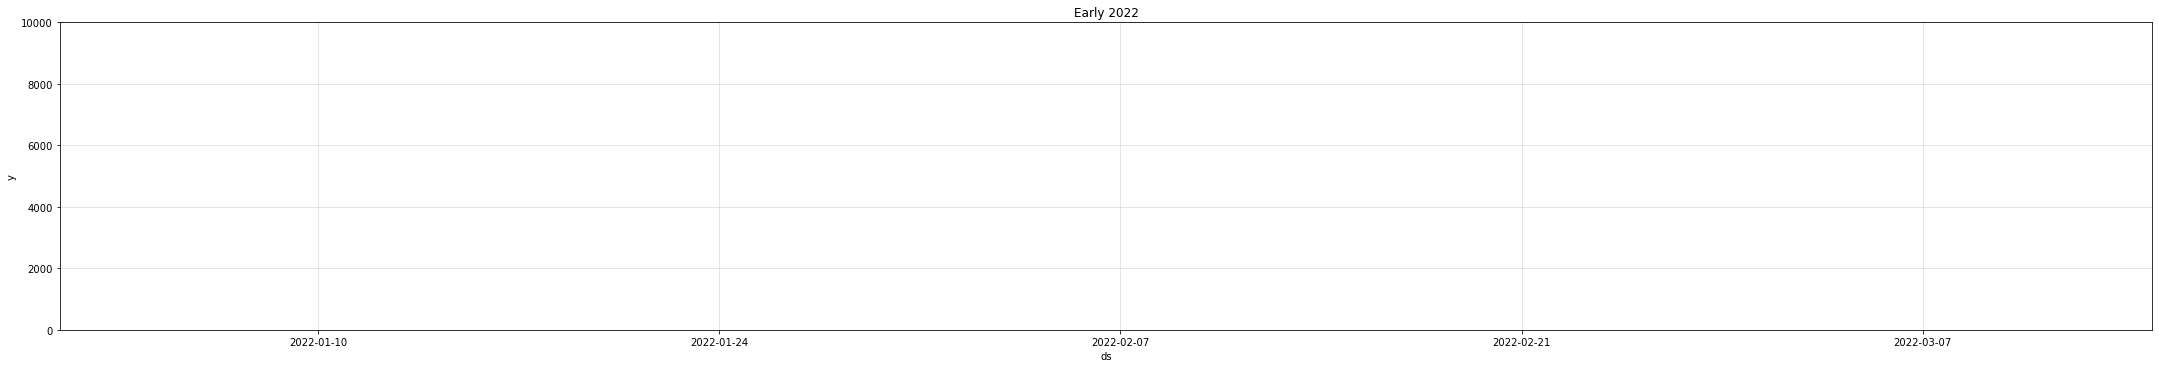

In [25]:
fig2 = m.plot(forecast, figsize=(30,5))
fig2.get_axes()[0].set(title='Early 2022', ylim=(0, 10000), xlim=(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-03-15')))

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


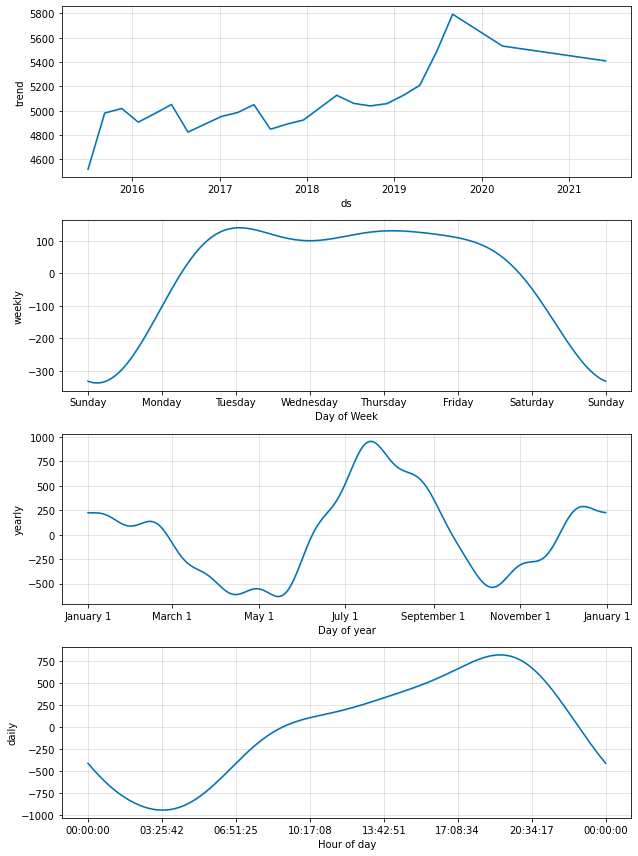

In [26]:
fig2 = m.plot_components(forecast)

In [28]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel='processes')

INFO:prophet:Making 6 forecasts with cutoffs between 2017-12-13 12:00:00 and 2020-05-31 12:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f27b04daa90>
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.app

Initial log joint probability = -340.437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -462.529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -435.155
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -619.313
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      99       53385.6   0.000225043       2605.08      0.2406      0.2406      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       64452.2     0.0051483       3010.47           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       73954.7    0.00850741       5373.

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1312       53600.3   2.42053e-06       73.4396      0.9281      0.9281     1712   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     899       85144.1    0.00189114       1288.87           1           1     1040   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1099       64676.6   0.000123152       156.638      0.6621      0.6621     1389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       74231.8    0.00478777       1386.93           1           1     1255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       85146.9    0.00371341       672.317           1           1     1148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       64678.3   0.000227657       643.343      0.4985      0.4985     1516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       74256.3    0.00186987       819.509      0.5356      0.5356     1371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       64681.7    0.00257015       314.862           1           1     1633   
    Iter      log 

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -573.305
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       74261.1     0.0100206       967.502           1           1     1485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1383       64682.8     4.667e-05       156.082   4.251e-07       0.001     1783  LS failed, Hessian reset 
    1399       64682.9   8.13993e-05       241.659      0.1831      0.1831     1805   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       85159.4    0.00410215       805.463           1           1     1386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       74269.6    0.00319198       824.665      0.1645           1     1599   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       97311.4     0.0106046    

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1830       64686.3   8.63178e-06       51.5136      0.5442      0.5442     2427   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1799       74277.6    0.00274134       322.356       0.332           1     2120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599       85173.2     0.0011913       897.104           1           1     1893   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       97633.1   0.000484205       1121.14           1           1      574   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1848       74277.8   2.71516e-05       124.897    2.57e-07       0.001     2233  LS failed, Hessian reset 
    1899         74278   0.000350544       132.332           1           1     2296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599         97698    0.00341953       1845.68           1           1      683   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -590.953
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699         85175    0.00101708       170.909           1           1     2065   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1938       74278.3   3.35912e-05       476.786   8.141e-08       0.001     2383  LS failed, Hessian reset 
     699       97723.8    0.00277871       639.907      0.3428           1      795   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1999       74278.5    0.00034811       418.201           1           1     2457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1799       85175.6   5.70615e-05       178.375           1           1     2188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        108388     0.0147907    

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    2081       74278.7   1.24549e-06       59.1661     0.07289           1     2617   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199        108676    0.00698216       1374.54           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       97755.3     0.0129858       3390.94      0.2699           1     1020   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1999       85176.7    0.00058039       414.328           1           1     2426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        108789    0.00562956       1281.51           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       97765.3    0.00128147       438.417           1           1     1140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    2017       85176.8   4.90475e-05       336.098   7.983e-07       0.001     2493  LS failed, Hessian r

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    2050       85176.8   3.25343e-05       78.5936           1           1     2537   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     399        108906    0.00255994       964.067      0.4389      0.4389      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       97775.9   0.000466521       211.514           1           1     1255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        108921    0.00287444       2648.37      0.5072           1      583   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199         97778   0.000162608       631.063           1           1     1370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299       97779.3   0.000137409       101.602           1           1     1483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        108941    0.00222232       824.548           1           1      695   
    Iter      log 

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     899        108991    0.00639987       2133.88           1           1     1035   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1584         97786   3.88516e-06       86.9831   2.146e-08       0.001     1902  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     999        109002   0.000610419       281.159           1           1     1150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1088        109005    1.3481e-05       347.742    4.37e-08       0.001     1294  LS failed, Hessian reset 
    1099        109005    0.00144056        741.95           1           1     1305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199        109007    0.00049199       601.205           1           1     1415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299        109010     0.0001905       397.889           1           1     1524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399        109011    0.00267259       509.058           1           1     1637   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1915        109029   6.68324e-05       76.5143           1           1     2340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [29]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-12-13 13:00:00,5601.374211,5089.345578,6127.327082,5080.0,2017-12-13 12:00:00
1,2017-12-13 14:00:00,5690.817395,5131.353963,6225.348598,5051.0,2017-12-13 12:00:00
2,2017-12-13 15:00:00,5775.053301,5244.600220,6322.896917,5064.0,2017-12-13 12:00:00
3,2017-12-13 16:00:00,5857.054438,5320.830055,6389.901226,5162.0,2017-12-13 12:00:00
4,2017-12-13 17:00:00,5947.739013,5426.336378,6491.751543,5525.0,2017-12-13 12:00:00
...,...,...,...,...,...,...
52365,2021-05-31 08:00:00,5207.365555,2749.343526,7679.004823,4129.0,2020-05-31 12:00:00
52366,2021-05-31 09:00:00,5379.508914,3008.904490,7858.353209,4389.0,2020-05-31 12:00:00
52367,2021-05-31 10:00:00,5481.986005,3137.285230,8047.694173,4533.0,2020-05-31 12:00:00
52368,2021-05-31 11:00:00,5547.842777,3306.937614,8079.955566,4610.0,2020-05-31 12:00:00


In [30]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [31]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 17:00:00,397428.673151,630.419442,501.207232,0.092858,0.076524,0.089514,0.628604
1,36 days 18:00:00,397755.526954,630.678624,501.393459,0.092909,0.076702,0.089557,0.628795
2,36 days 19:00:00,398121.501805,630.968701,501.676688,0.092971,0.076703,0.089614,0.628604
3,36 days 20:00:00,398266.967425,631.083962,501.831093,0.093001,0.076849,0.089641,0.628413
4,36 days 21:00:00,398158.303749,630.997864,501.691770,0.092977,0.076849,0.089617,0.628986
...,...,...,...,...,...,...,...,...
7875,364 days 20:00:00,648614.854054,805.366286,656.771536,0.129999,0.111653,0.131009,0.996181
7876,364 days 21:00:00,649073.877588,805.651213,657.030212,0.130039,0.111698,0.131037,0.996181
7877,364 days 22:00:00,649292.355800,805.786793,657.175580,0.130051,0.111808,0.131032,0.996181
7878,364 days 23:00:00,649357.254635,805.827062,657.331228,0.130061,0.111993,0.131020,0.996181


In [84]:
initial_days = 4 * 365
df_cv = cross_validation(m, initial=f'{initial_days} days', period='90 days', horizon = '2 days', parallel='processes')

INFO:prophet:Making 8 forecasts with cutoffs between 2019-09-07 12:00:00 and 2021-05-29 12:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f27aa8731c0>
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.app

Initial log joint probability = -584.027
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -616.104
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -844.967
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -567.189
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       97584.9    0.00255284       3537.91           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       91829.5    0.00376877       4923.89           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        103285     0.0255313       4582.16           1           1      127   
    Iter      log prob 

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1499        109120    0.00413331       638.776           1           1     1727   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1789       92515.3   0.000276956       50.0018           1           1     2101   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1899       97984.7    0.00108525       322.472           1           1     2201   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -589.929
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1951       97985.4   3.82471e-06       93.6466   2.312e-08       0.001     2311  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1599        109125   0.000289549       482.144           1           1     1849   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699        103782   0.000847142       472.886           1           1     1955   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -647.814
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        111520        0.0188       25505.5      0.3859           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699        109126   5.68113e-05       114.326      0.9368      0.9368     1966   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1773        103783   3.20063e-06       82.1997   2.219e-08       0.001     2096  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


      99        117083    0.00135875       1378.93           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199        111811    0.00680704       3757.49           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -613.407
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1753        109126    2.2658e-05       138.205   1.173e-07       0.001     2100  LS failed, Hessian reset 
    1754        109126   4.35728e-06       102.826       0.329           1     2102   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     199        117232    0.00739915       3750.68      0.4714           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        111907    0.00125887       2195.41           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -565.885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        122579    0.00200811       11851.2     0.07284           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        117319    0.00172526       1748.11           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        112038      0.012438       3268.54           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        128324     0.0026342       2934.07           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        122861    0.00726145       8307.87           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1248        112146   3.91327e-06       103.337   2.255e-08       0.001     1446  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     799        128871    0.00292926       1610.12      0.8053      0.8053      900   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        123070   0.000456358       553.986      0.5181      0.5181     1042   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199        117517     0.0169225       3876.19           1           1     1360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        123078    0.00206348       1850.74      0.7152      0.7152     1157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        128875   5.79215e-05       144.053           1           1     1012   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299        117525    0.00115442       378.838           1           1     1481   
    Iter      log 

/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1572        117534   0.000182051       82.1313           1           1     1842   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1204        128890   1.79472e-05       578.452    2.28e-08       0.001     1465  LS failed, Hessian reset 
    1499        123089   0.000446813       338.832        2.53       0.253     1723   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299        128892   0.000775041       872.457      0.5368      0.5368     1571   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1306        128892   3.16024e-06       98.9523   1.978e-08       0.001     1628  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    1599        123090   0.000119772       160.039           1           1     1835   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1699        123091   7.31774e-05       306.978      0.2194      0.2194     1951   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1799        123095   0.000142331       266.577           1           1     2068   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/michael/miniconda3/envs/ml-ops/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1897        123096   6.47088e-05       82.5214           1           1     2192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-09-07 13:00:00,6342.679305,5712.207751,6908.678502,6321.0,2019-09-07 12:00:00
1,2019-09-07 14:00:00,6415.718007,5798.301235,7006.354395,6631.0,2019-09-07 12:00:00
2,2019-09-07 15:00:00,6487.420748,5901.032818,7096.464469,6927.0,2019-09-07 12:00:00
3,2019-09-07 16:00:00,6561.537713,5988.198196,7145.016424,7217.0,2019-09-07 12:00:00
4,2019-09-07 17:00:00,6646.950356,6056.740464,7224.199350,7416.0,2019-09-07 12:00:00
...,...,...,...,...,...,...
379,2021-05-31 08:00:00,5049.302571,4427.138826,5709.424772,4129.0,2021-05-29 12:00:00
380,2021-05-31 09:00:00,5220.049121,4631.800079,5843.945883,4389.0,2021-05-29 12:00:00
381,2021-05-31 10:00:00,5324.533043,4712.480962,5942.558635,4533.0,2021-05-29 12:00:00
382,2021-05-31 11:00:00,5395.067302,4775.169804,6057.305561,4610.0,2021-05-29 12:00:00


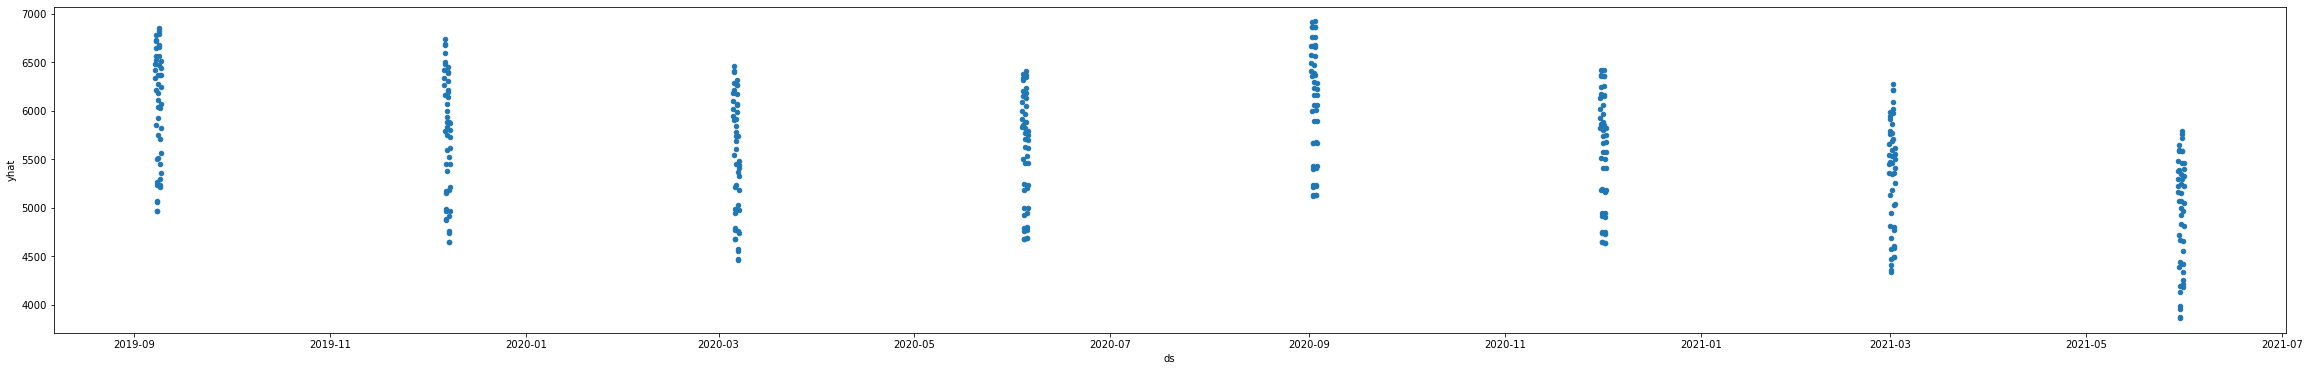

In [85]:
df_cv.plot.scatter('ds', 'yhat', figsize=(40, 6))
df_cv

In [86]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p
# (df_p.horizon - df_p.horizon.shift(1)).min()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,307284.988447,554.332922,453.624569,0.08532,0.074001,0.082528,0.692708


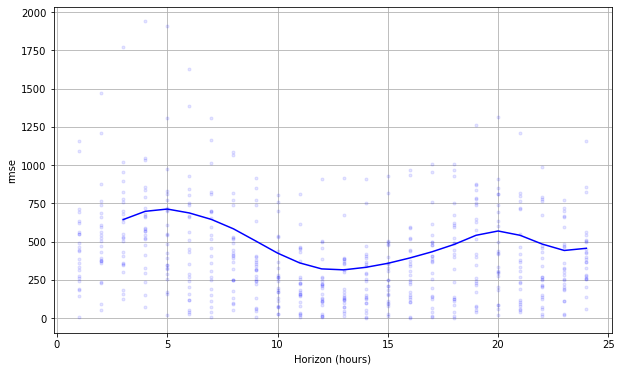

In [83]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [78]:
df_p['rmse'].values

array([375.66036434, 374.80724665, 372.15480218, 369.50066992,
       367.86220793, 369.59426196, 369.32264688, 375.67819264,
       384.29987456, 392.53375276, 398.54166234, 402.32034942,
       406.39884914, 410.1453307 , 414.24856589, 418.16657357,
       421.3001146 , 426.64743632, 434.88093759, 440.61268528,
       448.82132387, 454.97191732, 457.68500673, 458.08851382,
       455.46589841, 452.45690009, 448.21532133, 440.81223166,
       433.79077721, 433.75871356, 439.65397878, 451.97641448,
       467.36931761, 481.07171246, 491.78093141, 500.41334407,
       510.24125942])